# Variational AutoEncoders (VAE)

Source: [Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)

Supposed we have a dataset of images. Each image has hundreds of pixels, so each "data point" has hundreds of dimensions. The **manifold hypothesis** states that real-world high-dimensional data can be sufficiently described using only a few dimensions.

Examples of dimensionality reduction techniques include **autoencoder**, **principal component analysis** (PCA) and **t-SNE**.

## Autoencoder

Autoencoders are neural networks used to perform dimensionality reduction composed of two networks, an **encoder** $e$ and a **decoder** $d$.

The **encoder** learns a non-linear transformation $e: X \to Z$ that projects data from the high-dimensional input space $X$ to a lower-dimensional **latent space** $Z$. We call $z = e(x)$ a **latent vector**. 

A **latent vector** is a low-dimensional **representation** of a data point that contains information about $x$.

A **decoder** learns a non-linear transformation $d: Z \to X$ that projects the latent vectors back into the original high-dimensional input space $X$. This transformation should take the latent vector and reconstruct the original input data $\hat{x} = d(z)$.

An **autoencoder** is the composition of the encoder and the decoder

$$
f(x) = d(e(x))
$$

The autoencoder is trained to minimize the difference between the input $x$ and the reconstruction $\hat{x}$ using a kind of **reconstruction loss** and simultaneosly optimizes the encoder and the decoder. The **loss function** is usually either the **mean-squared error** or **cross-entropy** between the output and the input.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0) 

### Autoencoder Model

![AE](images/autoencoder.svg)

In [2]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, z_dim)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(z_dim, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = self.linear2(z)
        z = torch.sigmoid(z)
        return z.reshape((-1, 1, 28, 28))
    

class Autoencoder(nn.Module):
    def __init__(self, z_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

### Training of MNIST Data

We use a simple **mean squared error** as loss function:

$$
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y_i}) ^2
$$

In [3]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__();

    def forward(self, y_hat, y):
        return ((y - y_hat)**2).mean()

In [21]:
z_dim = 2
lr = 0.001
batch_size = 128
epochs = 1             # 80

trainset = datasets.MNIST('.', transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, drop_last=True)

testset = datasets.MNIST(root='.', transform=transforms.ToTensor(), download=True, train=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)

In [22]:
x, _ = next(iter(trainloader))
x[10,0,14,14]

tensor(0.9961)

In [4]:
autoencoder = Autoencoder(z_dim)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_fn = MSELoss()

epoch_losses = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x, _ in trainloader:
            optimizer.zero_grad()
            x_hat = autoencoder(x)
            loss = loss_fn(x, x_hat)
            epoch_loss = epoch_loss + loss.data
            loss.backward()
            optimizer.step()
        epoch_loss = epoch_loss / len(trainloader)
        pbar.set_description(f'Epoch {epoch}, Loss: {epoch_loss:.2f}')
        pbar.update()
        epoch_losses.append(epoch_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

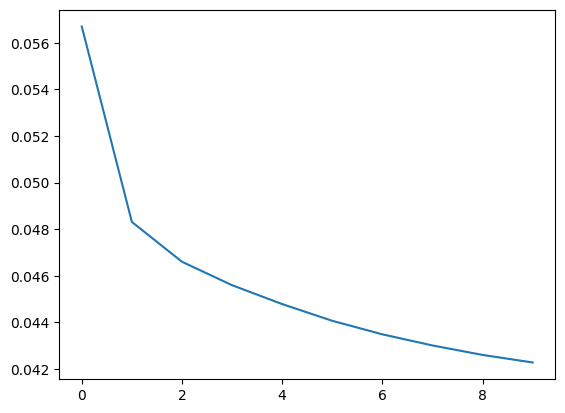

In [5]:
plt.plot(epoch_losses);

In [27]:
_trainset = datasets.MNIST('.', transform=transforms.ToTensor(), download=True)
_trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, drop_last=True)
_x, _ = next(iter(trainloader))
_x_hat = autoencoder(x)

In [28]:
loss_fn = nn.MSELoss()
loss = loss_fn(_x, _x_hat)
loss

tensor(0.0964, grad_fn=<MseLossBackward0>)

In [29]:
loss_fn = MSELoss()
loss = loss_fn(_x, _x_hat)
loss

tensor(0.0964, grad_fn=<MeanBackward0>)

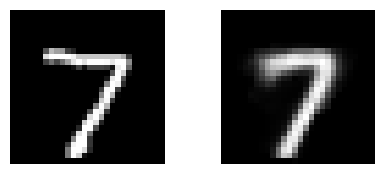

In [37]:
batch0 = next(iter(testloader))
img = batch0[0][0]
img_hat = autoencoder(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))
ax1.axis('off')
ax1.imshow(img.squeeze(0), cmap='gray')
ax2.axis('off')
ax2.imshow(img_hat.detach().squeeze(0).squeeze(0), cmap='gray');

### Latent Space

If we choose a **2-dimensional** latent space, then we can make a scatterplot of the output **latent vectors**.

It can easily been seen, that the encodings are **clustered** hence useful for **classification**.

The **fundamental problem** with autoencoders for **generation** is that the latent space they convert their inputs to and where their encoded vectors lie, may **not be continuous**, or allow easy interpolation.

If you build a generative model, then you want to randomly sample from the latent space, or generate variations on an input image, from a **continuous latent space**.

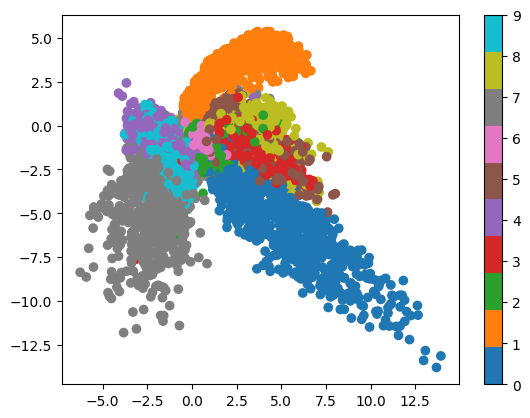

In [5]:
for x, y in testloader:
    z = autoencoder.encoder(x)
    z = z.detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar();

If we choose a **2-dimensional** latent space, then we can sample latent vectors $z$ from the latent space over a **uniform grid** and plot the decoded latent vectors on a grid.

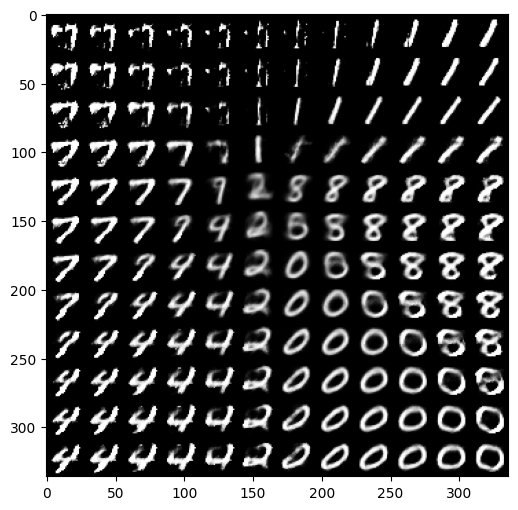

In [35]:
n = 12
w = 28
img = np.zeros((n * w, n * w))

for i, y in enumerate(np.linspace(-20, 10, 12)):
    for j, x in enumerate(np.linspace(-15, 20, 12)):
        z = torch.Tensor([[x, y]]).to(device)
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.reshape(28, 28).cpu().detach().numpy()
        img[(n - 1 - i) * w:(n - 1 - i + 1) * w, j * w:(j + 1) * w] = x_hat

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray');

If we sample a latent vector $z \sim Z$ from a region in the latent space that was never seen by the decoder during training, the output might not make any sense at all, see e.g. top-left corner.

The latent space $Z$ of an autoencoder can become **disjoint** and **non-continuous**. Variational autoencoders try to solve this problem.

## Variational Autoencoders

### How does a variational autoencoder differ from a simple autoendocer?

A variational autoencoder (VAE) differs from a simple autoencoder in that it is designed to learn a continuous latent space, rather than a discrete one. This means that the VAE is able to generate new, unseen data samples by sampling from this continuous latent space, rather than just reconstructing input data.

Additionally, the VAE uses a probabilistic approach to learning the latent space, by minimizing the difference between the distribution of the latent space and a prior distribution (usually a normal distribution). This allows the VAE to more accurately capture the underlying structure of the data.

Finally, the VAE includes a regularization term in its loss function, which helps to prevent overfitting and improve the generalization performance of the model.

### What is a Variational Autoencoder?

Instead of mapping the input $x$ to a latent vector $z=e(x)$, we map it to a **mean** vector $\mu(x)$ and a vector of **standard deviations** $\sigma(x)$ which parametrize a **diagonal Gaussian distribution** from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \, \sigma)$

This is modeled by replacing the last layer of an autoencoder with two layers, each of which outputs $\mu(x)$ and $\sigma(x)$.

There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an auxillary loss that penalizes the distribution $p\,(z∣x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$.

This penalty term is the **Kullback–Leibler divergence** between $p\,(z∣x)$ and $\mathcal{N}(0, 1)$ which is given by 

$$
D_{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

(see [here](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians))

### Kullback–Leibler Divergence

KL divergence measures how one probability distribution $p$ diverges from a second expected probability distribution $q$:

$$
D_{KL}(p \parallel q) = \int_{x \in X} p(x) \, \log \frac{p(x)}{q(x)} dx
$$

 $D_{KL}$ achieves the minimum zero when $p(x)$ equals $q(x)$ everywhere.


In [9]:
# this is the same example in wiki
P = torch.Tensor([0.36, 0.48, 0.16])
Q = torch.Tensor([0.333, 0.333, 0.333])

(P * (P / Q).log()).sum()
# tensor(0.0863), 10.2 µs ± 508

tensor(0.0863)

In [10]:
# kl_div expects the inputs as log-probabilities. 
# The targets are given as probabilities (i.e. without taking the logarithm).
F.kl_div(Q.log(), P, None, None, 'sum')
# tensor(0.0863), 14.1 µs ± 408 ns

tensor(0.0863)

## Variational Autoencoder Model

![VAE](images/variational-autoencoder.svg)

Implementing a variational autoencoder requires only to change the **encoder**:

In [11]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc.to(device)
        self.N.scale.to(device)
        self.mu = torch.tensor([0, 0])
        self.sigma = torch.tensor([1, 1])
#        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        self.mu = self.linear2(x)
#        print(f'mu: {mu}')
        self.sigma = torch.exp(self.linear3(x))
#        print(f'sigma: {sigma}')
        self.z = self.mu + self.sigma * self.N.sample(self.mu.shape)
#        print(f'z: {z}')
#        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
#        print(f'self.kl: {self.kl}')
        return self.z

In [12]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

### Training of MNIST Data

In [13]:
#class MSEKLLoss(nn.Module):
#    def __init__(self):
#        super(MSEKLLoss, self).__init__();
#
#    def forward(self, predictions, target, mu, sigma):
#        kl_divergence = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
#        loss_value = ((target - predictions)**2).sum() + kl_divergence
#        return loss_value
    
class MSEKLLoss(nn.MSELoss):
    def __init__(self):
        super().__init__();

    def forward(self, target, predictions, mu, sigma):
        kl_divergence = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return super().forward(target, predictions) + kl_divergence

In [14]:
z_dim = 2
lr = 0.001
batch_size = 128
#epochs = 80
epochs = 1


vae = VariationalAutoencoder(z_dim).to(device)

trainset = datasets.MNIST('.', transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
#loss_fn = MSEKLLoss()

epoch_losses = []
kl_losses = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x, y in trainloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = vae(x)
#            loss = loss_fn(x, x_hat, vae.encoder.mu, vae.encoder.sigma)
            
            kl_divergence = (vae.encoder.sigma**2 + vae.encoder.mu**2 - torch.log(vae.encoder.sigma) - 1/2).sum()
            loss = ((x - x_hat)**2).sum() + kl_divergence
#            print(((x - x_hat)**2))

            
            epoch_loss = epoch_loss + loss.data.cpu()
            loss.backward()
            optimizer.step()
        epoch_loss = epoch_loss / len(trainloader)
        epoch_losses.append(epoch_loss)
        pbar.set_description(f'Epoch {epoch}, Loss: {epoch_loss:.2f}')
        pbar.update()

  0%|          | 0/1 [00:00<?, ?it/s]

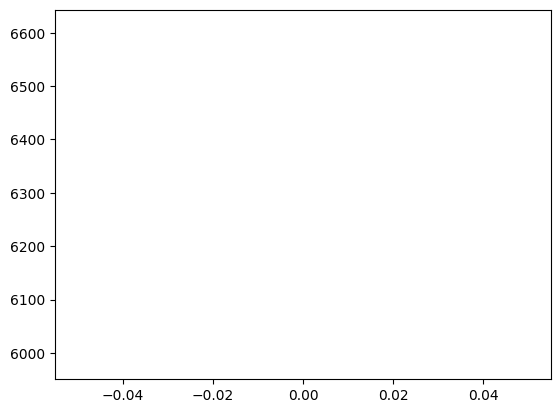

In [15]:
plt.plot(epoch_losses);

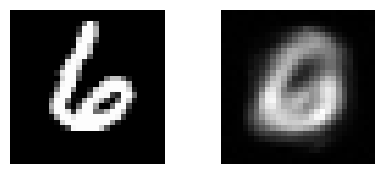

In [16]:
testset = datasets.MNIST(root='.', transform=transforms.ToTensor(), download=True, train=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True)

batch0 = next(iter(testloader))
img = batch0[0][0]
img_hat = vae(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))
ax1.axis('off')
ax1.imshow(img.squeeze(0), cmap='gray')
ax2.axis('off')
ax2.imshow(img_hat.detach().squeeze(0).squeeze(0), cmap='gray');

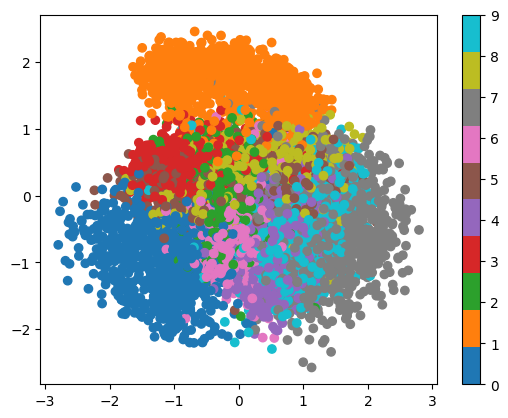

In [17]:
for x, y in testloader:
    z = vae.encoder(x.to(device))
    z = z.cpu().detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar();

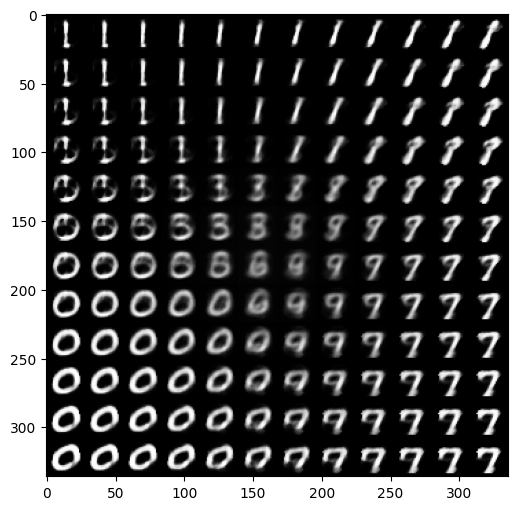

In [18]:
n = 12
w = 28
img = np.zeros((n * w, n * w))

for i, y in enumerate(np.linspace(-3, 3, 12)):
    for j, x in enumerate(np.linspace(-3, 3, 12)):
        z = torch.Tensor([[x, y]]).to(device)
        x_hat = vae.decoder(z)
        x_hat = x_hat.reshape(28, 28).cpu().detach().numpy()
        img[(n - 1 - i) * w:(n - 1 - i + 1) * w, j * w:(j + 1) * w] = x_hat

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray');